In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

device = device = "cuda" if torch.cuda.is_available() else "cpu"

In [67]:
!touch kaggle.json
!echo '{"kaggle.json": b"{"username":"Your_Username","key":"Your_API_KEY"}"}' > kaggle.json

# Setup

In [5]:
!pip install -q kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle
'chmod 600 root/.kaggle/kaggle.json'

'chmod 600 root/.kaggle/kaggle.json'

In [7]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:09<00:00, 83.3MB/s]
100% 812M/812M [00:09<00:00, 93.2MB/s]


In [8]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [9]:
!unzip train.zip
!unzip test1.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflatin

# Code

In [10]:
class DogsvsCatsDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        super().__init__()
        self.transform = transform or transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])

        self.image_folder = image_folder
        self.image_files = os.listdir(image_folder)
        self.labels = torch.tensor([0 if "dog" in filename else 1 for filename in self.image_files])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder, self.image_files[index])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        label = self.labels[index]
        return image, label


train_ds = DogsvsCatsDataset("/content/train/")
test_ds = DogsvsCatsDataset("/content/test1/")
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=4, shuffle=True)


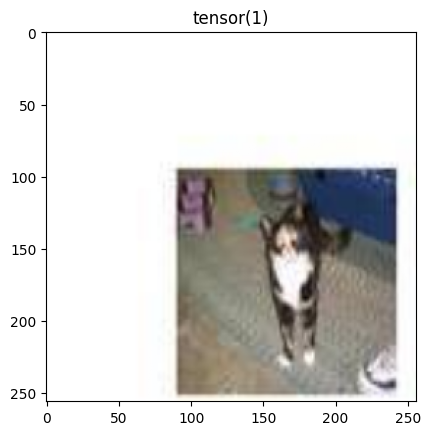

In [11]:
image, label = train_ds[0]

plt.imshow(image.permute(1, 2, 0).numpy())
plt.title(label)
plt.show()

In [12]:
print(image.shape)
print(label.shape)
print(len(train_dl))

torch.Size([3, 256, 256])
torch.Size([])
6250


# Network

In [13]:
class NeuralNet(nn.Module):

  def __conv_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
      )

  def __lin_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Linear(in_channels, out_channels),
        nn.ReLU()
    )

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = self.__conv_block(in_channels, 16)
    self.conv2 = self.__conv_block(16, 32)
    self.conv3 = self.__conv_block(32, 64)

    self.flatten = nn.Flatten()

    self.ln1 = self.__lin_block(61504, 500) # after flattening
    self.ln2 = self.__lin_block(500, 50)
    self.ln3 = nn.Linear(50, out_channels)

    self.softmax= nn.Softmax(dim=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)

    x = self.ln1(x)
    x = self.ln2(x)
    x = self.ln3(x)
    x = self.softmax(x)

    return x



In [14]:
model = NeuralNet(3, 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

loss_data, epoch_data = [], []

for epoch in range(15):
  running_batch_loss = 0.0
  for i, (images, labels) in enumerate(train_dl):
    optimizer.zero_grad()

    images,labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_batch_loss += loss.item()
    epoch_data.append(epoch + i/len(train_dl))
    loss_data.append(loss.item())

    if i % 2000 == 1999:
      print(f"Epoch: {epoch}, Loss: {running_batch_loss / 2000:.4f}")
      running_batch_loss = 0.0

Epoch: 0, Loss: 0.6629
Epoch: 0, Loss: 0.6035
Epoch: 0, Loss: 0.5835
Epoch: 1, Loss: 0.5563
Epoch: 1, Loss: 0.5504
Epoch: 1, Loss: 0.5340
Epoch: 2, Loss: 0.5159
Epoch: 2, Loss: 0.5155
Epoch: 2, Loss: 0.5128
Epoch: 3, Loss: 0.5001
Epoch: 3, Loss: 0.4931
Epoch: 3, Loss: 0.4909
Epoch: 4, Loss: 0.4755
Epoch: 4, Loss: 0.4806
Epoch: 4, Loss: 0.4713
Epoch: 5, Loss: 0.4662
Epoch: 5, Loss: 0.4592
Epoch: 5, Loss: 0.4566
Epoch: 6, Loss: 0.4491
Epoch: 6, Loss: 0.4450
Epoch: 6, Loss: 0.4419
Epoch: 7, Loss: 0.4230
Epoch: 7, Loss: 0.4281
Epoch: 7, Loss: 0.4309
Epoch: 8, Loss: 0.4150
Epoch: 8, Loss: 0.4160
Epoch: 8, Loss: 0.4118
Epoch: 9, Loss: 0.4017
Epoch: 9, Loss: 0.4035
Epoch: 9, Loss: 0.4052
Epoch: 10, Loss: 0.3924
Epoch: 10, Loss: 0.3910
Epoch: 10, Loss: 0.3922
Epoch: 11, Loss: 0.3858
Epoch: 11, Loss: 0.3881
Epoch: 11, Loss: 0.3833
Epoch: 12, Loss: 0.3745
Epoch: 12, Loss: 0.3782
Epoch: 12, Loss: 0.3783
Epoch: 13, Loss: 0.3717
Epoch: 13, Loss: 0.3755
Epoch: 13, Loss: 0.3752
Epoch: 14, Loss: 0.367

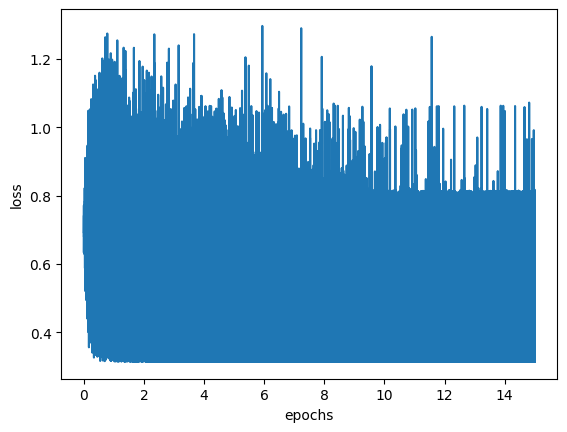

In [15]:
plt.plot(np.array(epoch_data), np.array(loss_data))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

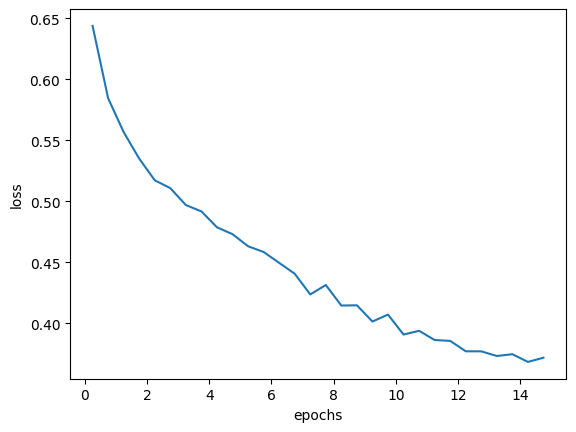

In [16]:
plt.plot(np.array(epoch_data).reshape(30, -1).mean(axis=1), np.array(loss_data).reshape(30, -1).mean(axis=1))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
!pip install torchmetrics
from torchmetrics import Precision, Recall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 7.8 MB/s eta 0:00:00


In [19]:
precision = Precision(task="multiclass", num_classes=10, average="macro").to(device)
recall = Recall(task="multiclass", num_classes=10, average="macro").to(device)

model.eval()
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor, with a dim of 1
    precision(preds, labels)
    recall(preds, labels)

print("Precision: {} & Recall: {}".format(precision.compute(), recall.compute()))

Precision: 0.5 & Recall: 0.257999986410141


In [20]:
precision = Precision(task="multiclass", num_classes=10, average="micro").to(device)
recall = Recall(task="multiclass", num_classes=10, average="micro").to(device)

model.eval()
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor, with a dim of 1
    precision(preds, labels)
    recall(preds, labels)

print("Precision: {} & Recall: {}".format(precision.compute(), recall.compute()))

Precision: 0.5166400074958801 & Recall: 0.5166400074958801


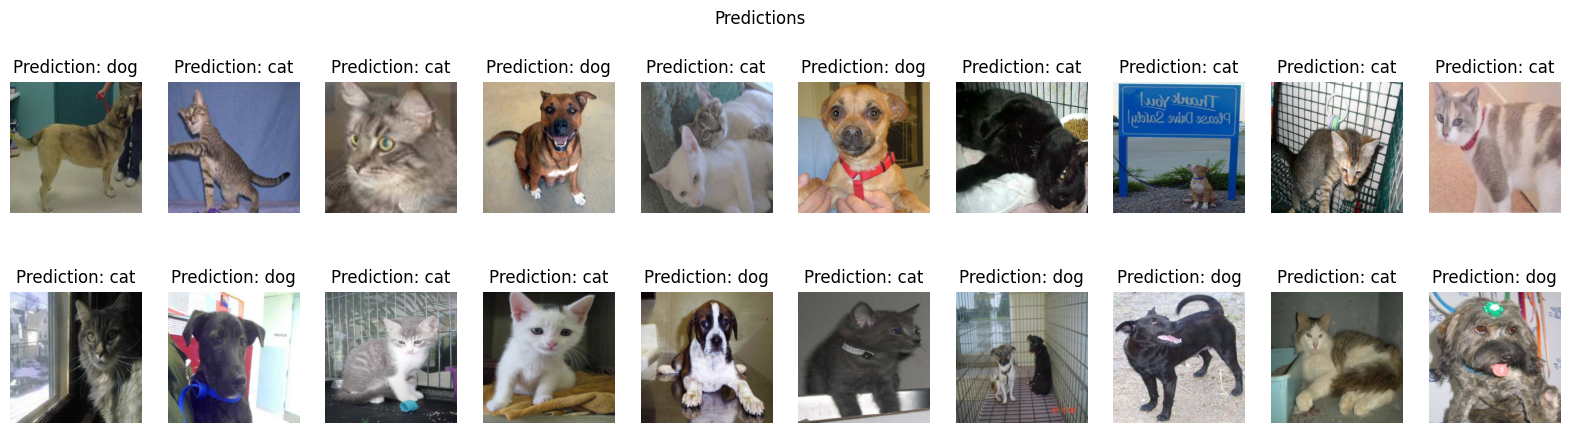

In [60]:
classes = ["dog", "cat"]

images = []
all_preds = []

for i, (batch_images, _) in enumerate(test_dl):
    batch_images = batch_images.to(device)
    labels = model(batch_images)
    preds = torch.argmax(labels, 1)

    images.append(batch_images.cpu())
    all_preds.extend(preds.cpu().numpy())

    if i == 21:
      break;


images = torch.cat(images, dim=0)

all_preds = torch.tensor(all_preds)

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
fig.suptitle("Predictions")
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f'Prediction: {classes[all_preds[i].item()]}')
    ax.axis('off')

plt.show()